# Black–Scholes Pricing, Greeks, and Implied Volatility (with JAX)

This notebook implements the **Black–Scholes** option pricing model for European calls and puts, computes the **Greeks** via automatic differentiation, and solves for **implied volatility** using a gradient-based approach (Newton–Raphson).  
It’s meant as a clear, reproducible reference for pricing workflows commonly used in derivatives analytics.

**What you’ll see**
- Closed-form Black–Scholes prices (calls & puts)
- Greeks computed with `jax.grad`
- Implied volatility solved to match a target market price
- Small experiments showing how price/Greeks move with **strike** and **volatility**, with quick plots

**When to use this**
- Fast pricing for European options
- Sensitivity analysis for risk (delta, gamma, vega, theta, rho)
- Inferring volatility from market prices (IV)

## Black-Scholes Equation

The Black–Scholes equation is a partial differential equation that governs the theoretical price of a derivative.

$$
\frac{\partial C}{\partial t} 
+ \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 C}{\partial S^2} 
+ r S \frac{\partial C}{\partial S} 
- r C = 0 
\quad where \quad C \ \text{is the price of some derivative}.
$$

$$
\text{Total derivative of $C$ with respect to $t$:} 
\quad \frac{dC}{dt}
$$

$$
\text{Partial derivative of $C$ with respect to $t$:} 
\quad \frac{\partial C}{\partial t}
$$

---

##  Black–Scholes Pricing Model

The model takes **six key inputs**:
$$
\begin{array}{ll}
\bullet \ S: & \text{Current underlying price (e.g. equity, futures, commodity, etc.)} \\
\bullet \ K: & \text{Strike price} \\
\bullet \ T: & \text{Time to maturity (in years, annualized)} \\
\bullet \ r: & \text{Risk-free interest rate} \\
\bullet \ \sigma: & \text{Volatility of the underlying stock} \\
\bullet \ q: & \text{Dividend yield}
\end{array}
$$

### **Call and Put Price Formulas**
The closed-form Black–Scholes prices for European options with continuous dividend yield are:

**Call option:**
$$
C = S e^{-qT} N(d_1) - K e^{-rT} N(d_2)
$$

**Put option:**
$$
P = K e^{-rT} N(-d_2) - S e^{-qT} N(-d_1)
$$

Here:
- Stock price discount factor:
$$
e^{-qT}
$$
discounts the stock price for expected dividends over the life of the option.

- Strike price discount factor:
$$
e^{-rT}
$$
discounts the strike price to its present value using the risk-free rate.

- Standard normal CDF:
$$
N(\cdot)
$$
is the cumulative distribution function of the standard normal distribution.

---

### **Interpreting $\mathbf{d_1}$ and $\mathbf{d_2}$**

The variables **$\mathbf{d_1}$** and **$\mathbf{d_2}$** capture the standardized “moneyness” of the option, adjusted for time and volatility:

$$
d_1 =
\frac{
    \ln\!\left(\frac{S}{K}\right)
    + \left(r - q + \frac{\sigma^2}{2}\right)T
}{
    \sigma \sqrt{T}
}
$$

$$
d_2 = d_1 - \sigma\sqrt{T}
$$

---

- **$\mathbf{d_1}$**:  

Measures how far the current underlying price \(S\) is above the strike \(K\) in standard deviation units, after accounting for the cost of carry \((r-q)\) and half the variance:
$$
\frac{\sigma^2}{2}
$$
In probabilistic terms, $\mathbf{(N(d_1)}$ can be interpreted as the **risk-neutral probability** the option finishes in-the-money, **weighted by exposure to the underlying**.

---

- **$\mathbf{d_2}$**:  

Equals $\mathbf{d_1}$ minus one volatility term:
$$
\sigma\sqrt{T}
$$
$\mathbf{N(d_2)}$ is the **risk-neutral probability of exercising the option** — the probability that the option finishes in-the-money, weighted by the exercise payoff at maturity.

---

**Summary intuition**:  
- The first term in each price formula represents the **present value of the expected asset payoff**, adjusted for dividends.  
- The second term represents the **present value of the expected strike payment** you must make if the option is exercised.  
- The difference between them gives the fair option price under no-arbitrage and risk-neutral assumptions.

In [3]:
import jax.numpy as jnp
from jax import grad
from jax.scipy.stats import norm as jnorm
import numpy as np
import pandas as pd
import yfinance as yf

In [4]:
def black_scholes(S, K, T, r, sigma, q=0, otype="call"):
    d1 = (jnp.log(S/K) + (r - q + 0.5 * sigma**2) * T) / (sigma * jnp.sqrt(T))
    d2 = d1 - sigma * jnp.sqrt(T)
    if otype == "call":
        call = S * jnp.exp(-q * T) * jnorm.cdf(d1) - K * jnp.exp(-r * T) * jnorm.cdf(d2)
        return call
    else:
        put = K * jnp.exp(-r * T) * jnorm.cdf(-d2) - S * jnp.exp(-q * T) * jnorm.cdf(-d1)
        return put
S = 100.0
K = 110.0
T = 0.8
r = 0.05
sigma = 0.2
q = 0.0

our_call = black_scholes(S, K, T, r, sigma, q, otype="call")
our_put = black_scholes(S, K, T, r, sigma, q, otype="put")

print(f"Our code prints {our_call} price for calls")
print("")
print(f"Our code prints {our_put} price for puts")

Our code prints 4.832782745361328 price for calls

Our code prints 10.519615173339844 price for puts


## The Greeks

Often we care not just about the price of the option, but also about the sensitivity of the price to changes in the underlying parameters.

1. How much does the option price change if the underlying price changes?

$$
\Delta = \frac{\partial C}{\partial S}
$$

2. How much does the option price change if the underlying price changes?

$$
\Gamma = \frac{\partial^2 C}{\partial S^2} = \frac{\partial \Delta}{\partial S}
$$

3. How much does the option price change if the time to maturity changes?

$$
\Theta = \frac{\partial C}{\partial T}
$$

4. How much does the option price change if the interest rate changes?

$$
\rho = \frac{\partial C}{\partial r}
$$

5. How much does the option price change if the volatility changes?

$$
\nu = \frac{\partial C}{\partial \sigma}
$$

In [22]:
# This is the function we need to use the derivatives
#def black_scholes(S, K, T, r, sigma, q=0, otype="call"):

#Compute delta
delta = grad(black_scholes, argnums = 0)
#Compute gamma
gamma = grad(delta, argnums = 0)
#Compute vega
vega = grad(black_scholes, argnums = 4)
#Compute theta
theta = grad(black_scholes, argnums = 2)
#Compute rho
rho = grad(black_scholes, argnums = 3)

our_delta = delta(S,  K, T, r, sigma, q, otype="call")
our_gamma = gamma(S,  K, T, r, sigma, q, otype="call")
our_vega = vega(S,  K, T, r, sigma, q, otype="call")
our_theta = theta(S,  K, T, r, sigma, q, otype="call")
our_rho = rho(S,  K, T, r, sigma, q, otype="call")


print(f"Delta: {our_delta}")
print()
print(f"Gamma: {our_gamma}")
print()
print(f"Vega: {our_vega}")
print()
print(f"Theta {our_theta}")
print()
print(f"Rho: {our_rho}")

Delta: 0.3423307538032532

Gamma: 0.020434020087122917

Vega: 32.694419860839844

Theta 4.354575157165527

Rho: 24.404205322265625


## Calculating Implied Volatility

Implied volatility (IV) is not directly observable — it must be **inferred** from market option prices using the **Black–Scholes model**.

---


## 1. Known vs Unknown


Taking notes we have the 6 parameters from the **Black–Scholes model**, but we also have one more piece of information:

- **$\mathbf{C}$** or **$\mathbf{P}$** — Observed market price of the Call or Put option

From these **7 parameters**, we typically know:

- **$\mathbf{S, K, T, r, q}$** from market data
- **$\mathbf{C}$** or **$\mathbf{P}$** from the market price


That leaves **$\mathbf{\sigma}$** — the volatility — as the only **unknown**.

---

## 2. Finding Implied Volatility

Since the Black–Scholes formula does not have a closed-form solution for **$\mathbf{\sigma}$**,  
we estimate it using **numerical methods**:

1. **Guess** an initial volatility value **$\mathbf{\sigma}$**
2. **Plug** it into the Black–Scholes pricing formula
3. **Compare** the theoretical option price to the actual market price
4. **Update** **$\mathbf{\sigma}$** to minimize the difference

This is essentially an **optimization problem**:
$$
\text{Loss}(\sigma) = \left[ \text{Market Price} - \text{BS Price}(\sigma) \right]
$$
We iterate until the loss is below a desired threshold, giving us the **implied volatility**.

---

*Key idea*: Implied volatility is *the volatility value that makes the Black–Scholes model match the observed option price.*

In [8]:
def loss(S, K, T, r, sigma_guess, price, q=0, otype="call"):
    
    #Price using the guessed volatility
    theoretical_price = black_scholes(S, K, T, r, sigma_guess, q, otype)

    #Actual price
    market_price = price

    #Loss is the difference between the theoretical price and the actual price
    #so what we want is to MINIMIZE this loss
    return theoretical_price - market_price
    
loss_grad = grad(loss, argnums = 4)

# Newton-Raphson Method

$x^g_{n+1}$ is our guess for the volatility.

$$
x^g_{n+1} = x^g_{n} - \frac{f\left(x^g_n\right)}{f'\left(x^g_n\right)}
$$

$f\left(x^g_n\right)$ is our loss function. This is just the difference between:


$$
\quad
\begin{array}{ll}
\bullet \ P_{\text{theory}}: & \text{Theoretical price (e.g. Black--Scholes valuation using our guess for the volatility)} \\
\bullet \ P_{\text{actual}}: & \text{Actual price (e.g. Market price)}
\end{array}
$$

$f'\left(x^g_n\right)$ is the gradient of the loss function.

More explicitly, it's the partial derivative of the loss function with respect to the volatility:

$$
\frac{\partial \mathcal{L}}{\partial \sigma}
$$

In [10]:
S = 100.0
K = 110.0
T = 0.8
r = 0.05
sigma = 0.2
q = 0.0
otype = "call"

price = black_scholes(S, K, T, r, sigma, q, otype)
print(f"Theoretical price of the option is: {price}")

Theoretical price of the option is: 4.832782745361328


In [11]:
def solve_for_iv(S, K, T, r, price, sigma_guess = 0.8, q=0, otype="call",
                 N_iter = 20, epsilon = 0.001):

    # 1. Initial guess for volatility
    sigma = sigma_guess
    
    
    for i in range(N_iter):
        
        # 2. Calculate the loss function
        loss_val = loss(S, K, T, r, sigma, price, q, otype)

        print(f"\nIteration: {i}")
        print("Current Error in Theoretical vs Market Price:")
        print(loss_val)
        
        # 3. Check if loss is within tolerance
        if abs(loss_val) < epsilon:
            break
    
        else:
            # 4. Calculate the gradient of the loss function
            loss_grad_val = loss_grad(S, K, T, r, sigma, price, q, otype)

        # 5. Update volatility using Newton-Raphson
        sigma = sigma - loss_val / loss_grad_val
        
    return sigma

calculated_implied_vol = solve_for_iv(S, K, T, r, price)
print("-----------------------------------------------------")
print(f"Optimized Implied Volatility: {calculated_implied_vol}")


Iteration: 0
Current Error in Theoretical vs Market Price:
21.149212

Iteration: 1
Current Error in Theoretical vs Market Price:
-0.571846

Iteration: 2
Current Error in Theoretical vs Market Price:
0.0025177002

Iteration: 3
Current Error in Theoretical vs Market Price:
0.0
-----------------------------------------------------
Optimized Implied Volatility: 0.19999998807907104


## Arbitrage Logic

For European options with continuous dividend yield \( q \), **put–call parity** states:

$$
C - P = S e^{-qT} - K e^{-rT}
$$

The **parity gap** is defined as:

$$
\text{Gap} = (C - P) - \left( S e^{-qT} - K e^{-rT} \right)
$$

---

### **$\mathbf{Case 1: Gap > 0}$** (calls overpriced) 

1. **Sell** the call  
2. **Buy** the put  
3. **Short** the underlying stock \(S\)  
4. **Invest** in a risk-free bond  

$$
K e^{-rT}
$$  



---

### **$\mathbf{Case 2: Gap < 0}$** (puts overpriced)

1. **Buy** the call  
2. **Sell** the put  
3. **Buy** the underlying stock \(S\)  
4. **Borrow** at the risk-free rate  

$$
K e^{-rT}
$$  


---

In either case, the position locks in a **risk-free profit** at maturity, assuming:

- European options (no early exercise)  
- Correctly modeled \( q \)  
- No transaction costs, bid–ask spreads, or liquidity issues  

In [13]:
def parity_gap(S, K, T, r, q, sigma):
    C = black_scholes(S=S, K=K, T=T, r=r, sigma=sigma, q=q, otype="call")
    P = black_scholes(S=S, K=K, T=T, r=r, sigma=sigma, q=q, otype="put")
    lhs = C - P
    rhs = S * jnp.exp(-q * T) - K * jnp.exp(-r * T)
    return lhs - rhs 

gap = parity_gap(100, 100, 0.5, 0.02, 0.01, 0.2)
print("Put–call parity gap:", gap)  # We should expect a value ≈ 0

Put–call parity gap: 0.0


## Calls impied volatility surface

A quick visualization of the implied volatilities for call options across strikes and expirations.
The surface shows $\sigma({K, T})$: implied volatility as a function of strike and time to maturity.

It takes **three key inputs**:

$$
\begin{array}{ll}
\bullet \ K: & \text{Strike price} \\
\bullet \ T: & \text{Time to maturity} \\
\bullet \ IV: & \text{Implied volatility} \\
\end{array}
$$


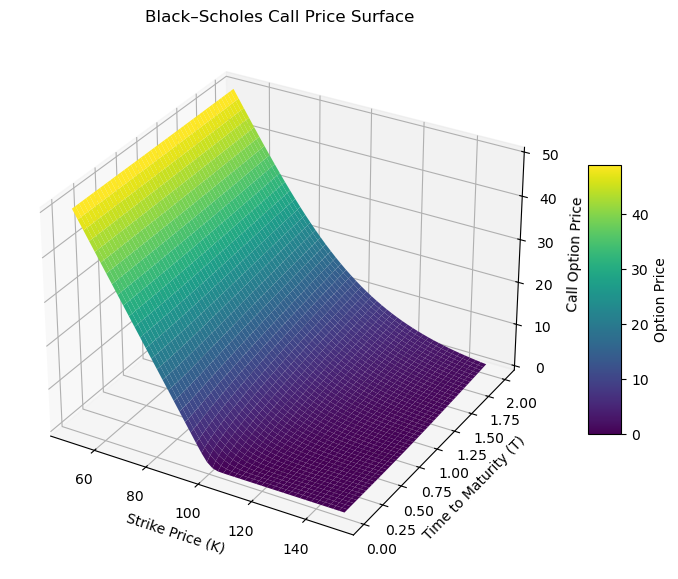

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting

# Parameters
S = 100.0
r = 0.02
q = 0.01
sigma = 0.2

# Ranges for strike and maturity
K_vals = np.linspace(50, 150, 50)
T_vals = np.linspace(0.01, 2.0, 50)  # start from 0.01 to avoid division by zero

# Meshgrid
K_grid, T_grid = np.meshgrid(K_vals, T_vals)

# Compute call prices
C_grid = np.zeros_like(K_grid)
for i in range(K_grid.shape[0]):
    for j in range(K_grid.shape[1]):
        C_grid[i, j] = float(black_scholes(S, K_grid[i, j], T_grid[i, j],
                                           r, sigma, q, otype="call"))

# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(K_grid, T_grid, C_grid, cmap='viridis', edgecolor='none')

ax.set_xlabel('Strike Price (K)')
ax.set_ylabel('Time to Maturity (T)')
ax.set_zlabel('Call Option Price')
ax.set_title('Black–Scholes Call Price Surface')

fig.colorbar(surf, shrink=0.5, aspect=8, label='Option Price')
plt.show()